In [3]:
import pandas as pd 
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import tensorflow as tf

csvfile = "Data.csv"  #file name 
#csvfile = "Data_actor2000.pt.csv"  #file name 

In [4]:
data_test= pd.read_csv(csvfile)
data_test.head()

,Episode,Kick_Speed,friction,variance_friction,Rewards,Stop_Distance
0,0,30.64,0.7,0.3,-227.06,61.20
1,1,44.44,0.7,0.3,-21.69,17.96
2,2,27.45,0.7,0.3,-252.69,68.06
3,3,27.25,0.7,0.3,-245.62,67.57
4,4,42.00,0.7,0.3,-30.25,25.04


In [3]:
profile = ProfileReport(data_test, minimal=True)
profile.to_file(output_file="output.html")

In [5]:
failed = data_test[data_test['Stop_Distance'] <= 0]
passed = data_test[data_test['Stop_Distance'] > 0]

print('Size of crashes :',failed.shape[0])  
print('Size of success :',passed.shape[0]) 
print("Percentage of crash cases:{:.2f}".format(failed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")
print("Percentage of not crashed cases:{:.2f}".format(passed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")

#failed.to_csv("crashed.csv",index=False)
#failed.head()

Size of crashes : 2848
Size of success : 3153
Percentage of crash cases:47.46 %
Percentage of not crashed cases:52.54 %


In [6]:
#passed.to_csv("not_crashed.csv",index=False  )
#passed.head()

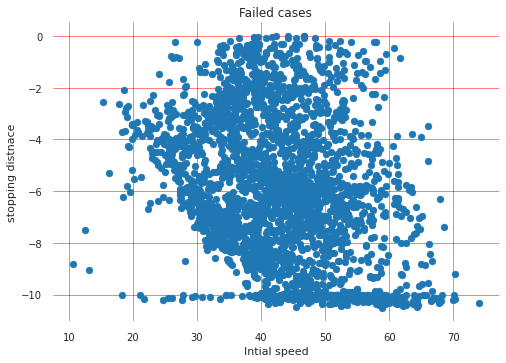

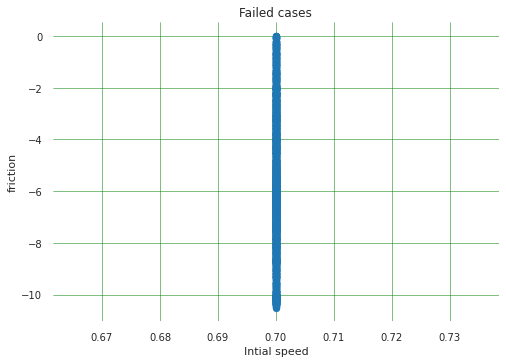

In [7]:
fig=plt.figure
plt.scatter(failed["Kick_Speed"],failed["Stop_Distance"],label='Line 2')
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("Intial speed")
plt.ylabel("stopping distnace")
plt.show()

fig=plt.figure
plt.scatter(failed["friction"],failed["Stop_Distance"],label='Line 2')
plt.grid(color='g', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("Intial speed")
plt.ylabel("friction")
plt.show()


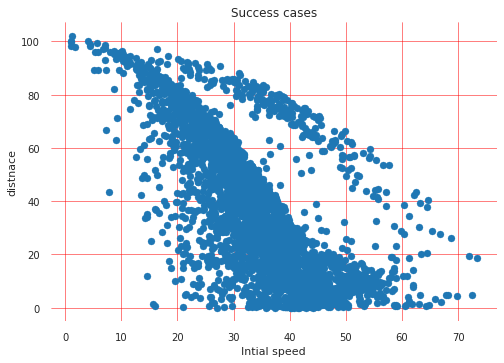

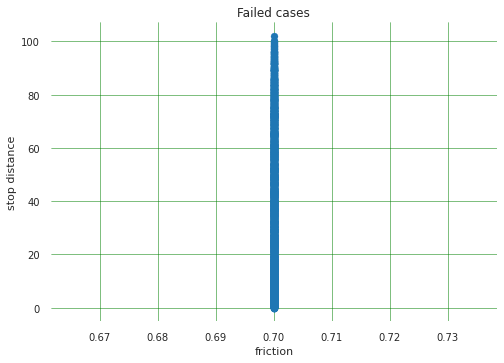

In [8]:
fig=plt.figure
plt.scatter(passed["Kick_Speed"],passed["Stop_Distance"])
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Success cases")
plt.xlabel("Intial speed")
plt.ylabel("distnace")
plt.show()

fig=plt.figure
plt.scatter(passed["friction"],passed["Stop_Distance"],label='Line 2')
plt.grid(color='g', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("friction")
plt.ylabel("stop distance")
plt.show()

In [9]:
data_test.loc[data_test['Stop_Distance'] <= 0, 'test'] = int(1)
data_test.loc[data_test['Stop_Distance'] > 0, 'test'] = int(0)
data_test.head()

,Episode,Kick_Speed,friction,variance_friction,Rewards,Stop_Distance,test
0,0,30.64,0.7,0.3,-227.06,61.20,0.0
1,1,44.44,0.7,0.3,-21.69,17.96,0.0
2,2,27.45,0.7,0.3,-252.69,68.06,0.0
3,3,27.25,0.7,0.3,-245.62,67.57,0.0
4,4,42.00,0.7,0.3,-30.25,25.04,0.0


Total number of episodes: 6001
Number of Pass: 3153
Number of fail: 2848


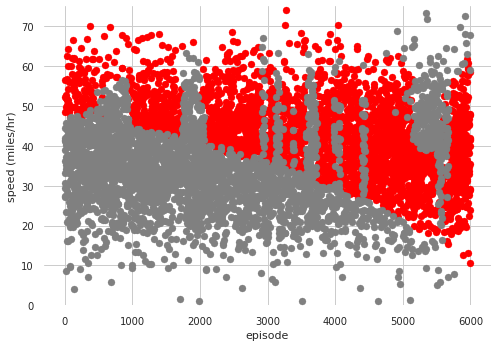

In [11]:
print('Total number of episodes:',data_test['Episode'].shape[0])
start=0
end=6001

fig, ax = plt.subplots()
episode=np.array(data_test['Episode'].values.tolist()[start:end])
test=np.array(data_test['test'].values.tolist()[start:end])
speed=np.array(data_test['Kick_Speed'].values.tolist()[start:end])

indices = test == 0
print('Number of Pass:',indices.sum())
print('Number of fail:',indices.shape[0]-indices.sum())

# normal values
ax.scatter(episode[~indices], speed[~indices], c = 'red',label='fail')
# bad values
ax.scatter(episode[indices], speed[indices], c = 'grey',label='Pass')
#ax.legend()
ax.set_ylim([0,75])
plt.xlabel('episode')
plt.ylabel('speed (miles/hr)')
ax.grid(True) 
plt.show()

Failures:  [97, 34, 169, 79, 208, 254, 268, 248, 360, 446, 312, 372]


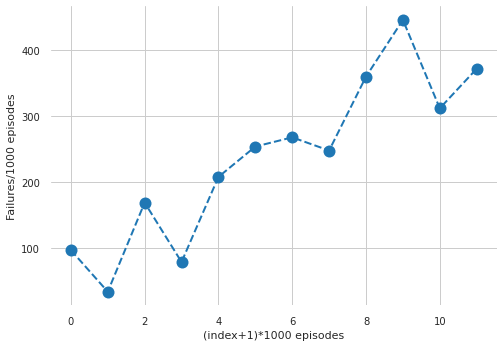

In [12]:
step=500
failure=[]
fig, ax = plt.subplots()
for i in range(int(data_test['Episode'].shape[0]/step)):
    start=step*i
    episode=np.array(data_test['Episode'].values.tolist()[start:start+step])
    test=np.array(data_test['test'].values.tolist()[start:start+step])
    indices = test == 1
    failure.append(indices.sum())
print('Failures: ',failure)
ax.plot(failure,marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('(index+1)*1000 episodes')
plt.ylabel('Failures/1000 episodes')
ax.grid(True) 
plt.show()   

In [15]:
#data for AVF training:
iteration_start=600
iteration_end=2000
data=data_test[["Episode", "Kick_Speed","test"]][iteration_start:iteration_end]
std=np.std(data[["Episode", "Kick_Speed"]].values,axis=0)
mean=np.mean(data[["Episode", "Kick_Speed"]].values,axis=0)
np.savez('stdmean.npz',std=std, mean=mean)
data[["Episode", "Kick_Speed"]]=np.divide(np.subtract(data[["Episode", "Kick_Speed"]],mean),std)
print('std is:',std)
print('Mean is:',mean)
data.head()

std is: [404.14508533  10.99963159]
Mean is: [1299.5          38.00997857]


,Episode,Kick_Speed,test
600,-1.730814,0.537293,0.0
601,-1.728340,0.632750,0.0
602,-1.725865,0.117279,0.0
603,-1.723391,1.265499,1.0
604,-1.720917,-0.332736,0.0


In [16]:
#AVF Training 


X=data[["Episode","Kick_Speed"]].values
print(X.shape)
Y=data["test"]
print(Y.shape)
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#test train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X[1,:].shape)

#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Model

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)), 
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid )
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=500, batch_size=8, callbacks=[callbacks]) ;


(1400, 2)
(1400,)
(2,)
Epoch 1/500
118/118 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.9680
Epoch 2/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0975 - accuracy: 0.9829
Epoch 3/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9829
Epoch 4/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0529 - accuracy: 0.9829
Epoch 5/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9851
Epoch 6/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9851
Epoch 7/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9893
Epoch 8/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9904
Epoch 9/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9893
Epoch 10/500
118/118 [==============================] - 0s 2ms/step 

118/118 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9979
Epoch 161/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9957
Epoch 162/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9979
Epoch 163/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.9957
Epoch 164/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9968
Epoch 165/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9968
Epoch 166/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9957
Epoch 167/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9968
Epoch 168/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9947
Epoch 169/500
118/118 [==============================] - 0s 2ms/step - loss: 0.0076 - a

In [17]:
results = model.evaluate(x_test, y_test, batch_size=16)
print('test loss, test acc:', results)

29/29 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.9978
test loss, test acc: [0.005865667946636677, 0.9978355169296265]


In [18]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [19]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [20]:
new_model = tf.keras.models.load_model('saved_model/my_model')

(5000, 2)
Data : [[2000.           49.20632132]
 [2000.           41.96943244]
 [2000.           44.8658065 ]
 ...
 [2000.           49.65757737]
 [2000.           40.06807762]
 [2000.           39.11290623]]


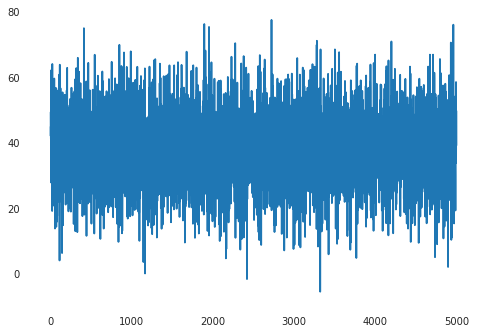

In [24]:
samples_per_iteration=5000
random_seed=np.random.randint(1,10000)
np.random.seed(random_seed)
candidate_initial_speed=[]
for i in range(samples_per_iteration): 
    #candidate_initial_speed =(9* np.random.randn(samples_per_iteration, 1) + 38).reshape(-1,1)
    candidate_initial_speed.append(np.random.normal(38,11))

candidate_initial_speed=np.array(candidate_initial_speed).reshape(-1,1)
Episode=2000*np.ones((samples_per_iteration,1)).reshape(-1,1)

data=np.concatenate((Episode,candidate_initial_speed),axis=1)
print(data.shape)
print('Data :',data)

container = np.load('stdmean.npz')
data_normalised=np.divide(np.subtract(data,container['mean']),container['std'])
plt.plot(candidate_initial_speed)

In [25]:
predicted_y=new_model.predict(data_normalised,batch_size=8)
max_value=np.amax(predicted_y)
print(max_value)
print(predicted_y.shape)
array_position=np.where(predicted_y==max_value)[0]
print(array_position)
#print(predicted_y)
#print(np.sort(predicted_y, axis=None) )
data_final=np.concatenate((data[array_position,:],predicted_y[array_position,:]),axis=1)
print(data_final)

0.99995637
(5000, 1)
[2721]
[[2.00000000e+03 7.74306546e+01 9.99956369e-01]]


In [74]:
data_final[0][1]

74.1494809483109